In [49]:
import pandas as pd
import matplotlib.pyplot as plt

In [50]:
df_pypi_decompiled_clustered = pd.read_csv("../../dataset/decompiled_syntax_errors_clustered.csv")

In [ ]:
df_pypi_syntax_repaired = pd.read_csv("../../dataset/decompiled_comparison_results_qwen_7b_enhanced.csv")

In [52]:
df_merged = pd.merge(df_pypi_decompiled_clustered, df_pypi_syntax_repaired, on="file_hash")

In [53]:
df_merged.head()

,file_hash,file,error_message,error_description,error,error_msg_clean,cluster,decompiled_file_name,raw_file_name,d_lookup_vs_decompiled,d_lookup_vs_repaired,status
0,025bcf101990c51854d7caa7c53055cdd6e9119e6c5e17...,decompiled_jvccommands.cpython-312.py,"invalid decimal literal (line 383, col 5)","File ""/home/diogenes/pylingual_colaboration/py...",invalid decimal literal (decompiled_jvccommand...,invalid decimal literal,cluster_1,decompiled_jvccommands.cpython-312.py,jvccommands.py,1118.0,1450.0,OK
1,008769cfa97d59dfa51e62b706c58395c46bc887a98199...,decompiled_NISQA_model.cpython-312.py,"'[' was never closed (line 106, col 703)","File ""/home/diogenes/pylingual_colaboration/py...",'[' was never closed (decompiled_NISQA_model.c...,'[' was never closed,cluster_5,decompiled_NISQA_model.cpython-312.py,NISQA_model.py,1037.0,1055.0,OK
2,0021a4762616818e8d4132c6c47a120fa08d8c5fa09938...,decompiled_feature_node_universes.cpython-312.py,closing parenthesis ')' does not match opening...,"File ""/home/diogenes/pylingual_colaboration/py...",closing parenthesis ')' does not match opening...,closing parenthesis ')' does not match opening...,cluster_2,decompiled_feature_node_universes.cpython-312.py,feature_node_universes.py,5001.0,5001.0,OK
3,00c778a21a451602c67e92625cfbad1c5ecd17c9407942...,decompiled_icl_prompt_template.cpython-312.py,unexpected character after line continuation c...,"File ""/home/diogenes/pylingual_colaboration/py...",unexpected character after line continuation c...,unexpected character after line continuation c...,cluster_1,decompiled_icl_prompt_template.cpython-312.py,icl_prompt_template.py,160.0,150.0,OK
4,008c16378fbd7120241739f31e6c167ed73c7d44255c20...,decompiled_bier_template.cpython-312.py,unterminated string literal (detected at line ...,"File ""/home/diogenes/pylingual_colaboration/py...",unterminated string literal (detected at line ...,unterminated string literal,cluster_3,decompiled_bier_template.cpython-312.py,bier_template.py,4210.0,3543.0,OK


In [54]:
df_merged.dropna(subset=["d_lookup_vs_decompiled", "d_lookup_vs_repaired"], inplace=True)

In [55]:
df_merged.shape

(342, 12)

In [56]:
df_merged["syntactic_drift"] = (
    (df_merged["d_lookup_vs_repaired"] - df_merged["d_lookup_vs_decompiled"])
    / df_merged["d_lookup_vs_decompiled"]
) * 100

In [57]:
df_merged.head()

,file_hash,file,error_message,error_description,error,error_msg_clean,cluster,decompiled_file_name,raw_file_name,d_lookup_vs_decompiled,d_lookup_vs_repaired,status,syntactic_drift
0,025bcf101990c51854d7caa7c53055cdd6e9119e6c5e17...,decompiled_jvccommands.cpython-312.py,"invalid decimal literal (line 383, col 5)","File ""/home/diogenes/pylingual_colaboration/py...",invalid decimal literal (decompiled_jvccommand...,invalid decimal literal,cluster_1,decompiled_jvccommands.cpython-312.py,jvccommands.py,1118.0,1450.0,OK,29.695886
1,008769cfa97d59dfa51e62b706c58395c46bc887a98199...,decompiled_NISQA_model.cpython-312.py,"'[' was never closed (line 106, col 703)","File ""/home/diogenes/pylingual_colaboration/py...",'[' was never closed (decompiled_NISQA_model.c...,'[' was never closed,cluster_5,decompiled_NISQA_model.cpython-312.py,NISQA_model.py,1037.0,1055.0,OK,1.735776
2,0021a4762616818e8d4132c6c47a120fa08d8c5fa09938...,decompiled_feature_node_universes.cpython-312.py,closing parenthesis ')' does not match opening...,"File ""/home/diogenes/pylingual_colaboration/py...",closing parenthesis ')' does not match opening...,closing parenthesis ')' does not match opening...,cluster_2,decompiled_feature_node_universes.cpython-312.py,feature_node_universes.py,5001.0,5001.0,OK,0.000000
3,00c778a21a451602c67e92625cfbad1c5ecd17c9407942...,decompiled_icl_prompt_template.cpython-312.py,unexpected character after line continuation c...,"File ""/home/diogenes/pylingual_colaboration/py...",unexpected character after line continuation c...,unexpected character after line continuation c...,cluster_1,decompiled_icl_prompt_template.cpython-312.py,icl_prompt_template.py,160.0,150.0,OK,-6.250000
4,008c16378fbd7120241739f31e6c167ed73c7d44255c20...,decompiled_bier_template.cpython-312.py,unterminated string literal (detected at line ...,"File ""/home/diogenes/pylingual_colaboration/py...",unterminated string literal (detected at line ...,unterminated string literal,cluster_3,decompiled_bier_template.cpython-312.py,bier_template.py,4210.0,3543.0,OK,-15.843230


In [58]:
cluster_stats = (
    df_merged
    .groupby("cluster")["syntactic_drift"]
    .agg(["count", "mean", "std"])
    .reset_index()
)

print(cluster_stats)


     cluster  count       mean         std
0  cluster_0      4  46.031518   95.602022
1  cluster_1    159  77.289220  666.715725
2  cluster_2      4 -17.223459   49.006141
3  cluster_3     44  -0.174056   57.498690
4  cluster_4     89  54.773143  145.342665
5  cluster_5     42   5.544907   85.857869


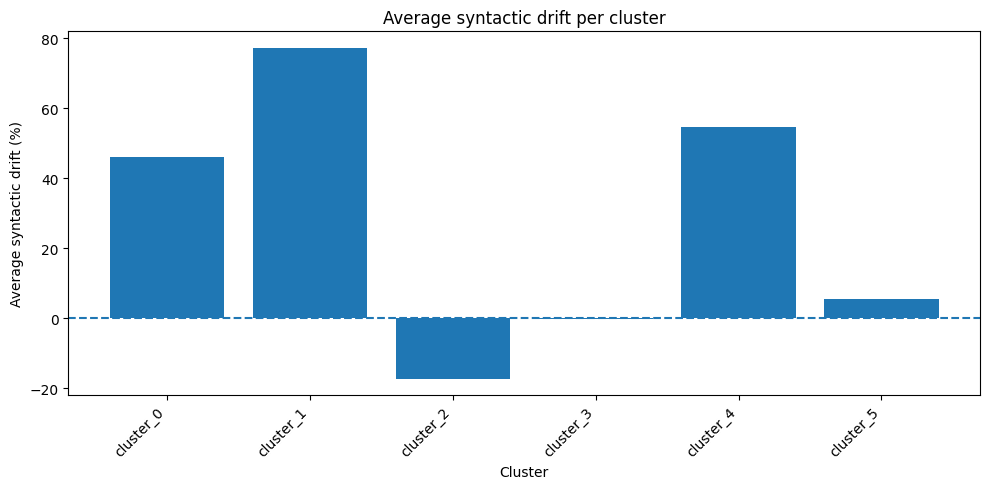

In [59]:
# (Optional) sort clusters by name
cluster_stats = cluster_stats.sort_values("cluster")

plt.figure(figsize=(10, 5))
plt.bar(cluster_stats["cluster"], cluster_stats["mean"])
plt.axhline(0, linestyle="--")  # show zero line for reference
plt.xlabel("Cluster")
plt.ylabel("Average syntactic drift (%)")
plt.title("Average syntactic drift per cluster")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

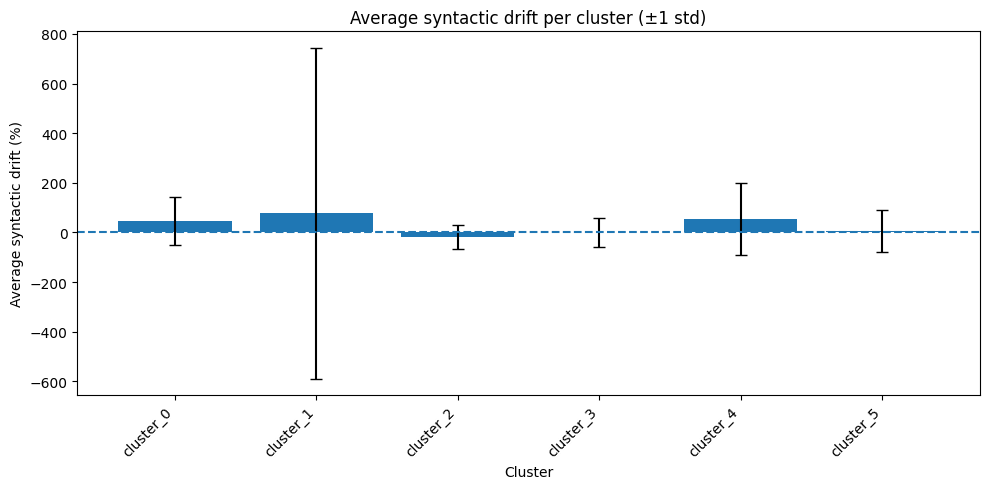

In [60]:
plt.figure(figsize=(10, 5))
plt.bar(
    cluster_stats["cluster"],
    cluster_stats["mean"],
    yerr=cluster_stats["std"],
    capsize=4,
)
plt.axhline(0, linestyle="--")
plt.xlabel("Cluster")
plt.ylabel("Average syntactic drift (%)")
plt.title("Average syntactic drift per cluster (±1 std)")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


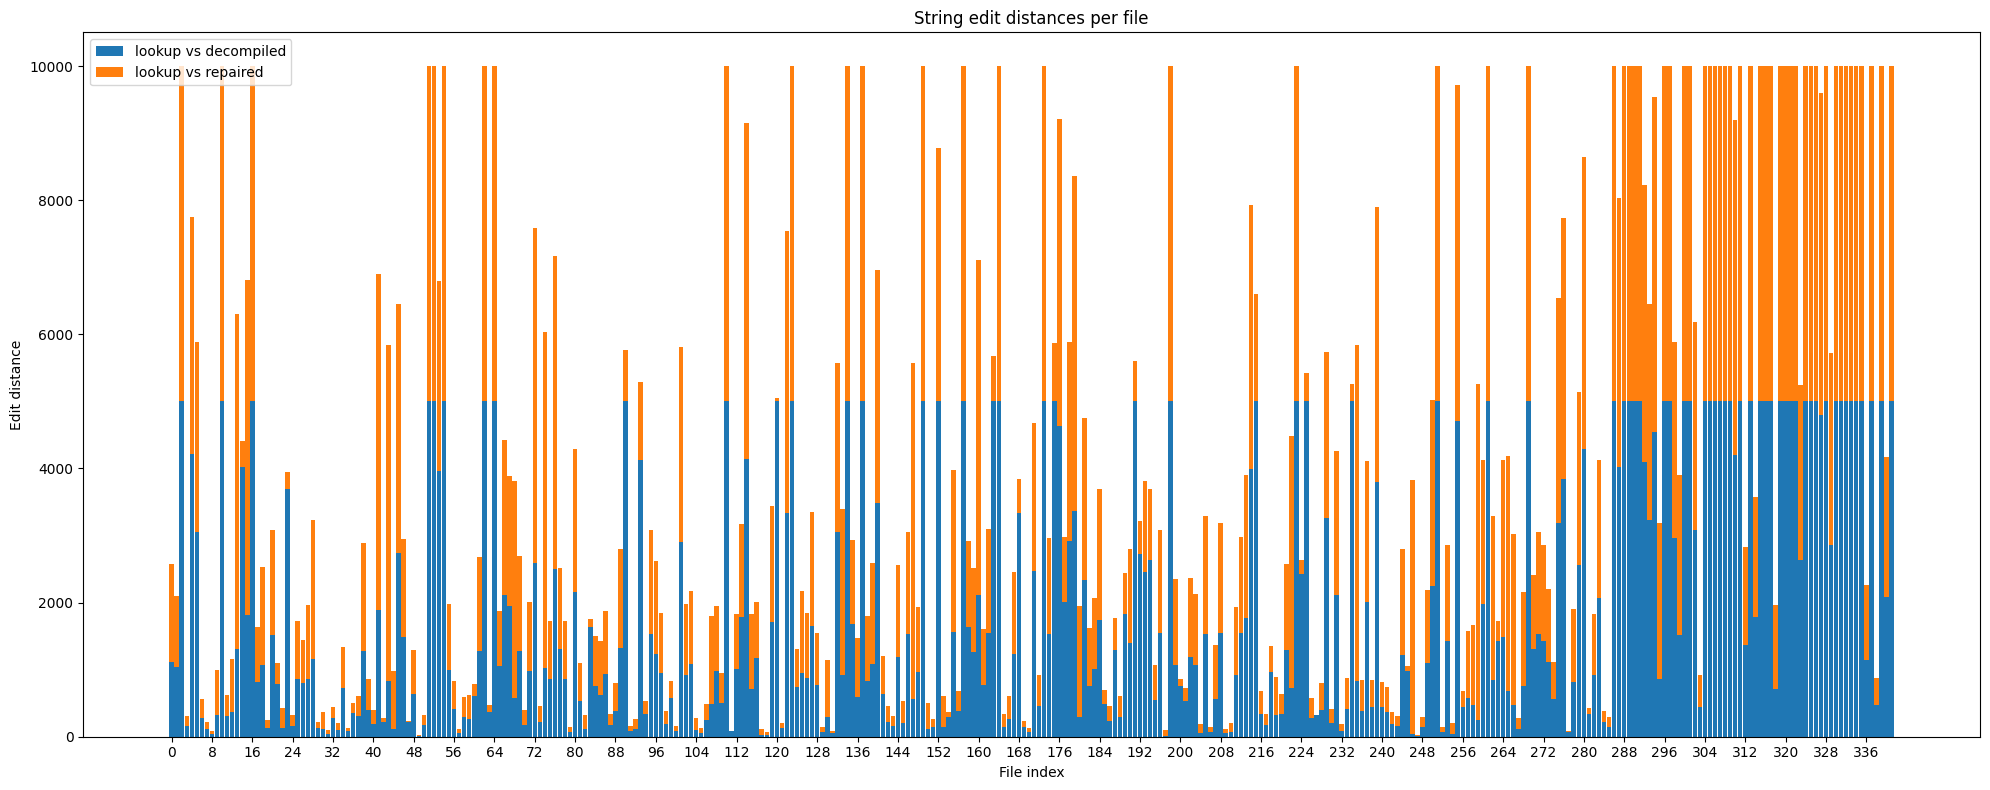

In [61]:
import matplotlib.pyplot as plt

# Prepare data
df_plot = df_merged.reset_index(drop=True)

x = df_plot.index  # file index on x-axis
d_dec = df_plot["d_lookup_vs_decompiled"]
d_rep = df_plot["d_lookup_vs_repaired"]

plt.figure(figsize=(20, 8))  # wider & taller

bar_width = 0.9  # make bars wider (max is ~1.0 for touching bars)

# bottom stack: distance to decompiled
plt.bar(x, d_dec, width=bar_width, label="lookup vs decompiled")

# top stack: distance to repaired, stacked on top
plt.bar(x, d_rep, width=bar_width, bottom=d_dec, label="lookup vs repaired")

plt.xlabel("File index")
plt.ylabel("Edit distance")
plt.title("String edit distances per file")
plt.legend()

# Make x-axis readable (e.g., show every Nth tick)
if len(x) > 40:
    step = max(1, len(x) // 40)
    plt.xticks(range(0, len(x), step))
else:
    plt.xticks(x)

plt.tight_layout()
plt.show()
